Working with 889 images
Image examples: 
0.jpg


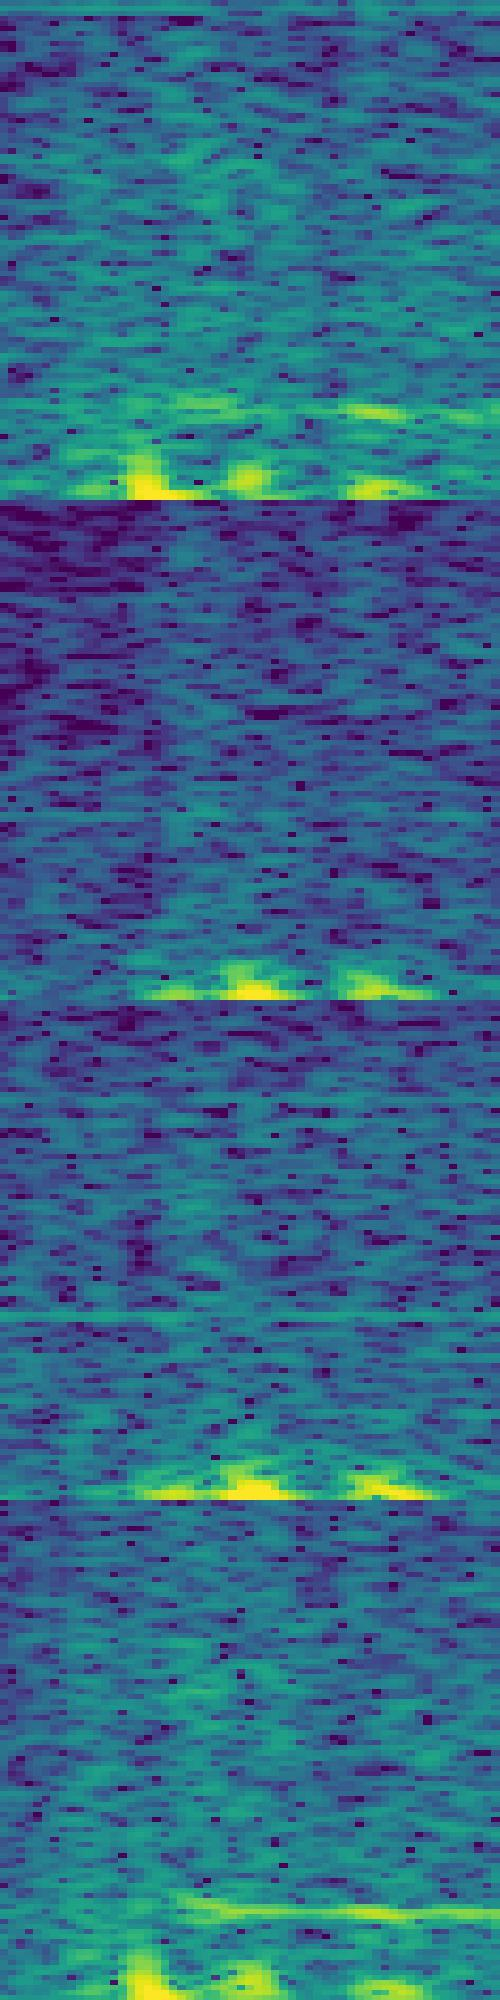

In [1]:
"""
    Check files in path
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

image_path = "./datasets/spectrogram/"
label_path = './datasets/'
jpgfiles = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]

print("Working with {} images".format(len(jpgfiles)))
print("Image examples: ")

idx = 0
print(jpgfiles[idx])
display(_Imgdis(filename=image_path + "/" + jpgfiles[idx], width=240))

In [2]:
"""
    Load files
"""

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_images = []
train_labels = np.load(label_path+'labels.npy')
i=0
for file in jpgfiles:
    train_images.append(file)
print("Files in train_files: %d" % len(train_images))
print(train_labels.shape)

Using TensorFlow backend.


Files in train_files: 889
(889,)


In [3]:
"""
    Convert from Image --> NP Array
"""

# Original Dimensions
image_width = 500
image_height = 2000
ratio = 5
channels = 4 # eLectrodoes

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

dataset = np.ndarray(shape=(len(train_images), channels, int(image_height / channels), image_width),
                     dtype=np.float32)
i = 0
for idx, file in enumerate(train_images):
    image = load_img(image_path+file)
    image.thumbnail((image_width, image_height))
    image = image.convert('L') # greyscale
    
    data = img_to_array(image)
    data = data.reshape(image_height, image_width)
    data = (data - 128.0) / 128.0
    
    spectro = []
    split = int(image_height/4)
    start = 0
    for end in range(split, image_height+split, split):
        spectro.append(data[start:end])
        start = end
    spectro = np.array(spectro)
    
    dataset[idx] = spectro
    
    if (idx+1) % 100 == 0:
        print("{} of {} images were processed.".format(idx+1, len(train_images)))
print("All images were processed!")

100 of 889 images were processed.
200 of 889 images were processed.
300 of 889 images were processed.
400 of 889 images were processed.
500 of 889 images were processed.
600 of 889 images were processed.
700 of 889 images were processed.
800 of 889 images were processed.
All images were processed!


(889,)
(889, 4, 100, 100)


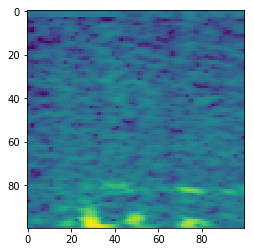

In [5]:
import matplotlib.pyplot as plt
print(train_labels.shape)
print(dataset.shape)
plt.imshow(dataset[0][0])
plt.show()

In [6]:
"""
    Save Dataset
"""
np.save('./datasets/spectro4ch.npy', dataset)

In [7]:
"""
    Further Process --> CNN
"""

raw = dataset.copy()

dataset = []
for idx in range(raw.shape[0]):
    rows = []
    for row in range(raw.shape[2]):
        cols = []
        for col in range(raw.shape[3]):
            channels = []
            for channel in range(raw.shape[1]):
                channels.append(raw[idx][channel][row][col])
            cols.append(channels)
        rows.append(cols)
    dataset.append(rows)
dataset = np.array(dataset)
print(dataset.shape)

np.save('./datasets/spectro4chCNN.npy', dataset)

(889, 100, 100, 4)


(889, 4, 100, 100)


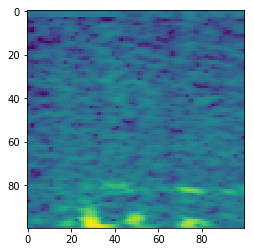

(889, 100, 100, 4)


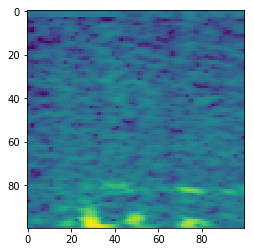

In [8]:
"""
    Confirm Processing Results
"""

import matplotlib.pyplot as plt
print(raw.shape)
plt.imshow(raw[0,0,:,:])
plt.show()

print(dataset.shape)
plt.imshow(dataset[0,:,:,0])
plt.show()

In [20]:
"""
    Further Process --> RNN
"""

# (files, channel, band, values) --> (files, timestep, features)
# timesteps == values
# features == channel and band --> (TP9 delta, AF7 delta, AF8 delta, TP10 delta, TP9 theta ...)
raw = np.load('./datasets/Power_per_band.npy')
print("Raw")
print(raw.shape)

dataset = []
for idx in range(raw.shape[0]):
    timesteps = []
    for timestep in range(raw.shape[3]):
        features = []
        for band in range(raw.shape[2]):
            for channel in range(raw.shape[1]):
                features.append(raw[idx][channel][band][timestep])
        timesteps.append(features)
    dataset.append(timesteps)
dataset = np.array(dataset)
print("Processed")
print(dataset.shape)
np.save('./datasets/Power_per_bandCNN.npy', dataset)

Raw
(889, 4, 5, 60)
Processed
(889, 60, 20)


In [9]:
"""
    Dataset Split
"""

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, train_labels, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

Train set size: 711, Val set size: 89, Test set size: 89
(711, 100, 100, 4)
(711,)
(89, 100, 100, 4)
(89,)
(89, 100, 100, 4)
(89,)
